## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these 

For this project, I will be working to understand the results of an A/B test run by an e-commerce website.  My goal is to work through this notebook to help the company understand if they should implement the new page, keep the old page, or perhaps run the experiment longer to make their decision.

8c12f60e43d0/rubric).

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [61]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.

a. Read in the dataset and take a look at the top few rows here:

In [62]:
df = pd.read_csv('data/ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [63]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [64]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [65]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [66]:
df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")')['user_id'].count()

3893

f. Do any of the rows have missing values?

In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [68]:
df2 = df.drop(df.query('(group == "treatment" and landing_page != "new_page") or (group != "treatment" and landing_page == "new_page")').index)

In [69]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [70]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [71]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [72]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [73]:
df2[df2['user_id']==773192]

,user_id,timestamp,group,landing_page,converted
1899,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


In [74]:
df2.drop(df2[df2.user_id.duplicated()].index, inplace=True)

`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [75]:
Pcov = df2.converted.mean()
Pcov

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

W'll compute a conditionally probability P(converted =1 / group =control) = P(converted =1 and group = control) / P(group = control)

In [76]:
b = df2.query('(group =="control") and (converted ==1)').user_id.count()

In [77]:
b/df2.query('group =="control"').user_id.count()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

W'll compute a conditionally probability P(converted =1 / group =treatment) = P(converted =1 and group = treatment) / P(group = treatment)

In [78]:
c = df2.query('(group =="treatment") and (converted ==1)').user_id.count()

In [79]:
c/df2.query('group =="treatment"').user_id.count()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [80]:
df2.query('landing_page =="new_page"').user_id.count()/df2.user_id.count()

0.50006194422266881

e. Use the results in the previous two portions of this question to suggest if you think there is evidence that one page leads to more conversions?  Write your response below.

From results above, we obtainded:
1. given that an individual was in the control group, the probability they converted is 12.04% 
and
2. given that an individual was in the treatement group, the probability they converted is 11.89%

The two probablities are quite similar, so there is no evidence that one page leads to more conversions.

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

 **H0** :   **$p_{old}$**  - **$p_{new}$** ≥ 0 (null hypothesis)
 
 **H1** :   **$p_{old}$**  - **$p_{new}$** < 0 (alternative hypothesis)

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [81]:
p_new = df2.converted.mean()
np.round(p_new,4)

0.1196

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [82]:
p_old = df2.converted.mean()
np.round(p_old,4)

0.1196

c. What is $n_{new}$?

In [83]:
n_new = df2[df2['landing_page']== 'new_page'].user_id.count()
n_new

145310

d. What is $n_{old}$?

In [84]:
n_old = df2[df2['landing_page']== 'old_page'].user_id.count()
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [105]:
 # np.random.binomial(n, p, size)
# n=1 trial size, p=probability of success, size = Output shape
# use binomial function to create an old page sample is the same 
# as I create a sample from df2 and use choice from this sample.

old = np.random.binomial(1, p_old, n_old)
old_page_converted = old.mean()
old_page_converted

0.11989068931811611

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [106]:
new_page_converted = np.random.binomial(1, p_new, n_new).mean()
new_page_converted

0.11834698231367421

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [107]:
P_diffs_obs  = new_page_converted - old_page_converted
P_diffs_obs 

-0.0015437070044418966

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in **p_diffs**.

In [96]:
p_diffs = []
size = 10000
for _ in range(size):
    old_page_converted = np.random.binomial(1, p_old, n_old).mean()
    new_page_converted = np.random.binomial(1, p_new, n_new).mean()
    p_diffs.append(new_page_converted - old_page_converted)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

(array([   28.,   151.,   623.,  1747.,  2742.,  2607.,  1505.,   475.,
          107.,    15.]),
 array([ -4.33147419e-03,  -3.44978376e-03,  -2.56809332e-03,
         -1.68640289e-03,  -8.04712456e-04,   7.69779770e-05,
          9.58668410e-04,   1.84035884e-03,   2.72204928e-03,
          3.60373971e-03,   4.48543014e-03]),
 <a list of 10 Patch objects>)

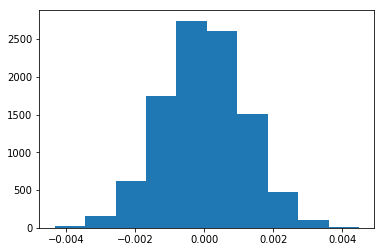

In [97]:
plt.hist(p_diffs)

0.0012036163748647959

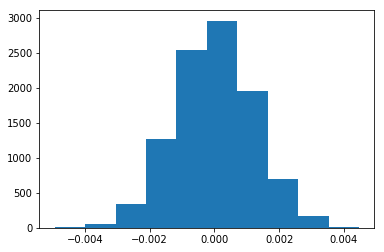

In [94]:
p_diffs = np.array(p_diffs)
null_vals = np.random.normal(0,p_diffs.std(),10000)
plt.hist(null_vals)
p_diffs.std()

> **Comment**: We know that for a large trails number, a normal distribution is a good approximation of a binomial function.
This is what we can see by the two plots above, one a large number binomial experience and the second is a normal distribution under the null hypothesis.

> Yes, the p_diffs histograph plot look like what I expected;  a normal distribution centred on 0.

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [109]:
# H0: Pnew - pold ≤ 0 
# H1: Pnew - pold > 0 
# p-value = p_diffs > P_diffs_obs
p_value = (p_diffs > P_diffs_obs).mean()
p_value

0.90090000000000003

k. In words, explain what you just computed in part **j.**.  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

> **Comment**: In the part g., we computed the difference of convertion rate in our sample. Comparing the actual difference observed to p_diffs (or null_vals) distribution tells us the likelihhod of our statistic coming from the null hypothesis.

> **In part j**, we computed the p_value (the probability of obtainig the observed statistic or one 'more extreme' in favor of the alternative hypothesis). 
The obtained p_value is 0.90 and it is vastly greater than 0.05 (Type I error rate of 5%). So we fail to reject the H0 hypothesis and therefore there is no statistically significant difference between the new and old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [110]:
import statsmodels.api as sm

convert_old = df2.query('(landing_page == "old_page") and (converted==1)')['user_id'].count()
convert_new = df2.query('(landing_page == "new_page") and (converted==1)')['user_id'].count()
n_old = df2.query('landing_page == "old_page"')['user_id'].count()
n_new = df2.query('landing_page == "new_page"')['user_id'].count()

/opt/conda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [111]:
z_score, p_value = sm.stats.proportions_ztest([convert_new,convert_old],[n_new,n_old], alternative = 'larger')
print(z_score, p_value)

-1.31092419842 0.905058312759


In [135]:
from scipy.stats import norm

#  Tells us what our critical value at 95% confidence is
print(norm.ppf(0.05/2))      # at 2.5%
print(norm.ppf(1-(0.05/2)))  # at 95.5%


-1.95996398454
1.95996398454


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

> **Comment**: Since the z-score of -1.31092419842 doesn't exceed the confidence interval (-1.95996398454 to 1.95996398454) in the standard normal distribution, we fail to reject the null hypothesis that the difference between the two converted ratios is less than zero. Therefore, the converted ratio for new_page has no difference to the converted ratio for old_page. This result is the same as we get in parts j. and k.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

We should be performing a **logistic regression** since the output variable or the **y** is a categorical variable.

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a colun for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [127]:
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [129]:
df2['intercept'] = 1
df2[['no_ab_page','ab_page']] = pd.get_dummies(df2['group'])
df2 = df2.drop('no_ab_page',axis = 1)
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [130]:
logis = sm.Logit(df2['converted'], df2[['intercept','ab_page']])
results = logis.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [131]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Tue, 20 Nov 2018   Pseudo R-squ.:               8.077e-06
Time:                        18:40:26   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in the **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

> *The p_value of ab_page is 0.19

> Why does it differ from the value you found in the Part II? In regression model:

> the hypothesis test is:

 >H0: β = 0 correlation between converted and ab_page
 
 >H1: β ≠ 0 correlation between converted and ab_page
 
 >It is two_tailled, in the opposite of the hypothesis test in part II, when :
 
 >**H0** :   **$p_{old}$**  - **$p_{new}$** ≥ 0 
 
 >**H1** :   **$p_{old}$**  - **$p_{new}$** < 0 

It is a one_tailled hypotheseis test.

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

> **Comment**: As we can see in the previous question, the ab_page is insignificant for predicting the individual that converts. Therefore, add more variables is required. However, add more terms leads to the **Collinearity problem**, which means that when we have predictor variables that are correlated with one another. One of the main concerns of multicollinearity is that it can lead to coefficients being flipped from the direction we expect from simple linear regression.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy varaibles.** Provide the statistical output as well as a written response to answer this question.

In [144]:
countries = pd.read_csv('data/countries.csv')
df_new = df2.merge(countries, on ='user_id', how='left')
print(df_new.country.unique())
df_new.head() 

['UK' 'US' 'CA']


,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [145]:
### Create the necessary dummy variables
df_new[['CA', 'UK', 'US']] = pd.get_dummies(df_new['country'])

In [148]:
logis2 = sm.Logit(df_new['converted'], df_new[['intercept','ab_page','US','UK']])
result = logis2.fit()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


In [149]:
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Tue, 20 Nov 2018   Pseudo R-squ.:               2.323e-05
Time:                        20:18:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
                                        LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
US             0.0408      0.027      1.516      0.130      -0.012       0.093
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
==============================================================================
"""

In [150]:
# We need to exponantial each coef of the added term
np.exp(0.0408), np.exp(0.0506)

(1.0416437559600236, 1.0519020483004984)

> **Comment**: Given the p_values, add country terms has no affect on conversion.  US users are 1.04 times as likly to converts holding all other cariables constant. UK users are 1.05 times as likly to converts holding all other cariables constant. As we can see,  there is no significant number of users that convert considering the country.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [151]:
df_new['page_CA'] = df_new['ab_page']*df_new['CA']
df_new['page_UK'] = df_new['ab_page']*df_new['UK']
df_new['page_US'] = df_new['ab_page']*df_new['US']

In [154]:
# We must add the two variables of interaction: the US and ab_page 
logis4 = sm.OLS(df_new['converted'], df_new[['intercept', 'ab_page', 'US', 'page_US', 'UK', 'page_UK']])
result = logis4.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              converted   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     1.466
Date:                Tue, 20 Nov 2018   Prob (F-statistic):              0.197
Time:                        21:07:39   Log-Likelihood:                -85265.
No. Observations:              290584   AIC:                         1.705e+05
Df Residuals:                  290578   BIC:                         1.706e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.1188      0.004     31.057      0.000       0.111       0.126
ab_page       -0.0069      0.005     -1.277      0.202      -0.017       0.004
US             0.0018      0.004      0.467      0.641      -0.006       0.010
page_US        0.0047      0.006      0.845      0.398      -0.006       0.016
UK             0.0012      0.004      0.296      0.767      -0.007       0.009
page_UK        0.0080      0.006      1.360      0.174      -0.004       0.020
==============================================================================
Omnibus:                   125549.436   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           414285.945
Skew:                           2.345   Prob(JB):                         0.00
Kurtosis:                       6.497   Cond. No.                         26.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

>**Comment**: As we can see in the summary, there is no significant effects on conversion when we add the interaction variable between page and country. The p_value of page_UK and page_US decrease but still greater than 0.05, which means that these variables are insignificant for predicting response.

<a id='conclusions'></a>
## Finishing Up

> Congratulations!  You have reached the end of the A/B Test Results project!  This is the final project in Term 1.  You should be very proud of all you have accomplished!

> **Tip**: Once you are satisfied with your work here, check over your report to make sure that it is satisfies all the areas of the rubric (found on the project submission page at the end of the lesson). You should also probably remove all of the "Tips" like this one so that the presentation is as polished as possible.


## Directions to Submit

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [1]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Analyze_ab_test_results_notebook.ipynb'])

0

In [2]:
!tar chvfz notebook.tar.gz *

Analyze_ab_test_results_notebook.html
Analyze_ab_test_results_notebook.ipynb
data/
data/ab_data.csv
data/countries.csv
